## 11. Alignment of Model Scales

## Numerical experiments - Week 04/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

The goal of this study is to cross-verify and combine the functionalities of the high-resolution, medium-resolution and low-resolution models, in order to obtain a universal mathematical relationship between cell wall permeability, spore density and spore coverage due to clustering.

## Prerequisite libraries

In [1]:
using PyPlot
using CurveFit
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting

## 1. Spore clusters in the medium and low-resolution models

The first experiment compares a high-resolution simulation of a 6-neighbour cluster and asymmetric subsets of it with varying distances on a lattice of size $L=256\times 0.2\mu\textrm{m}$ with an absorbing boundary to a medium-resolution and a low-resolution simulation of analogical clusters on a lattice of size $L=256\times 5\mu\textrm{m}$ and $L=64\times 20\mu\textrm{m}$, respectively, with a periodic boundary. This aims to investigate the following questions:
- Does the absorbing boundary bias results compared to a free flow in a much larger space domain?
- Can the medium and low-resolution model be used for a continuation of the distance-versus-decay-exponent function for larger distances?

To this end, a range of center-to-center distances between $2R$ and $20R$ are simulated. The resolution of each model permits a specific sub-range of this set:
- high resolution: $d_s=[2R, 5R]$;
- medium resolution: $d_s=[4R, 40R]$, whereby the direct neighbourhood of spore sites is avoided;
- low resolution: $d_s=[8R, 40R]$.

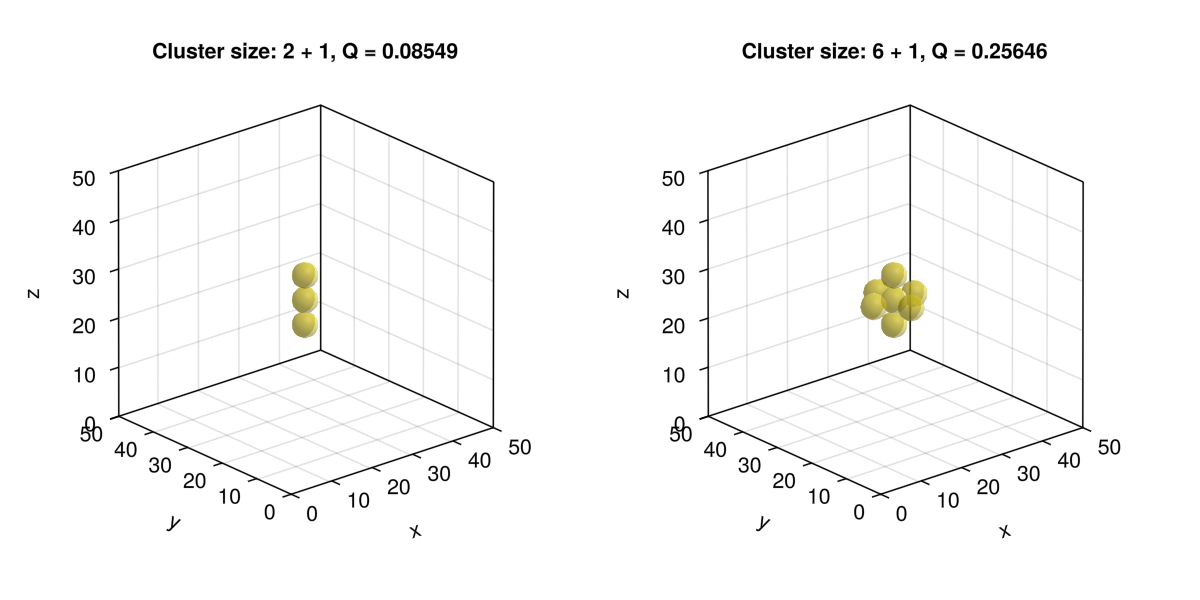

GLMakie.Screen(...)

In [5]:
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
n_nbrs = [2, 6]
plot_spore_clusters(n_nbrs, spore_rad, 50, 2; spore_spacings=[spore_diameter, spore_diameter])

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


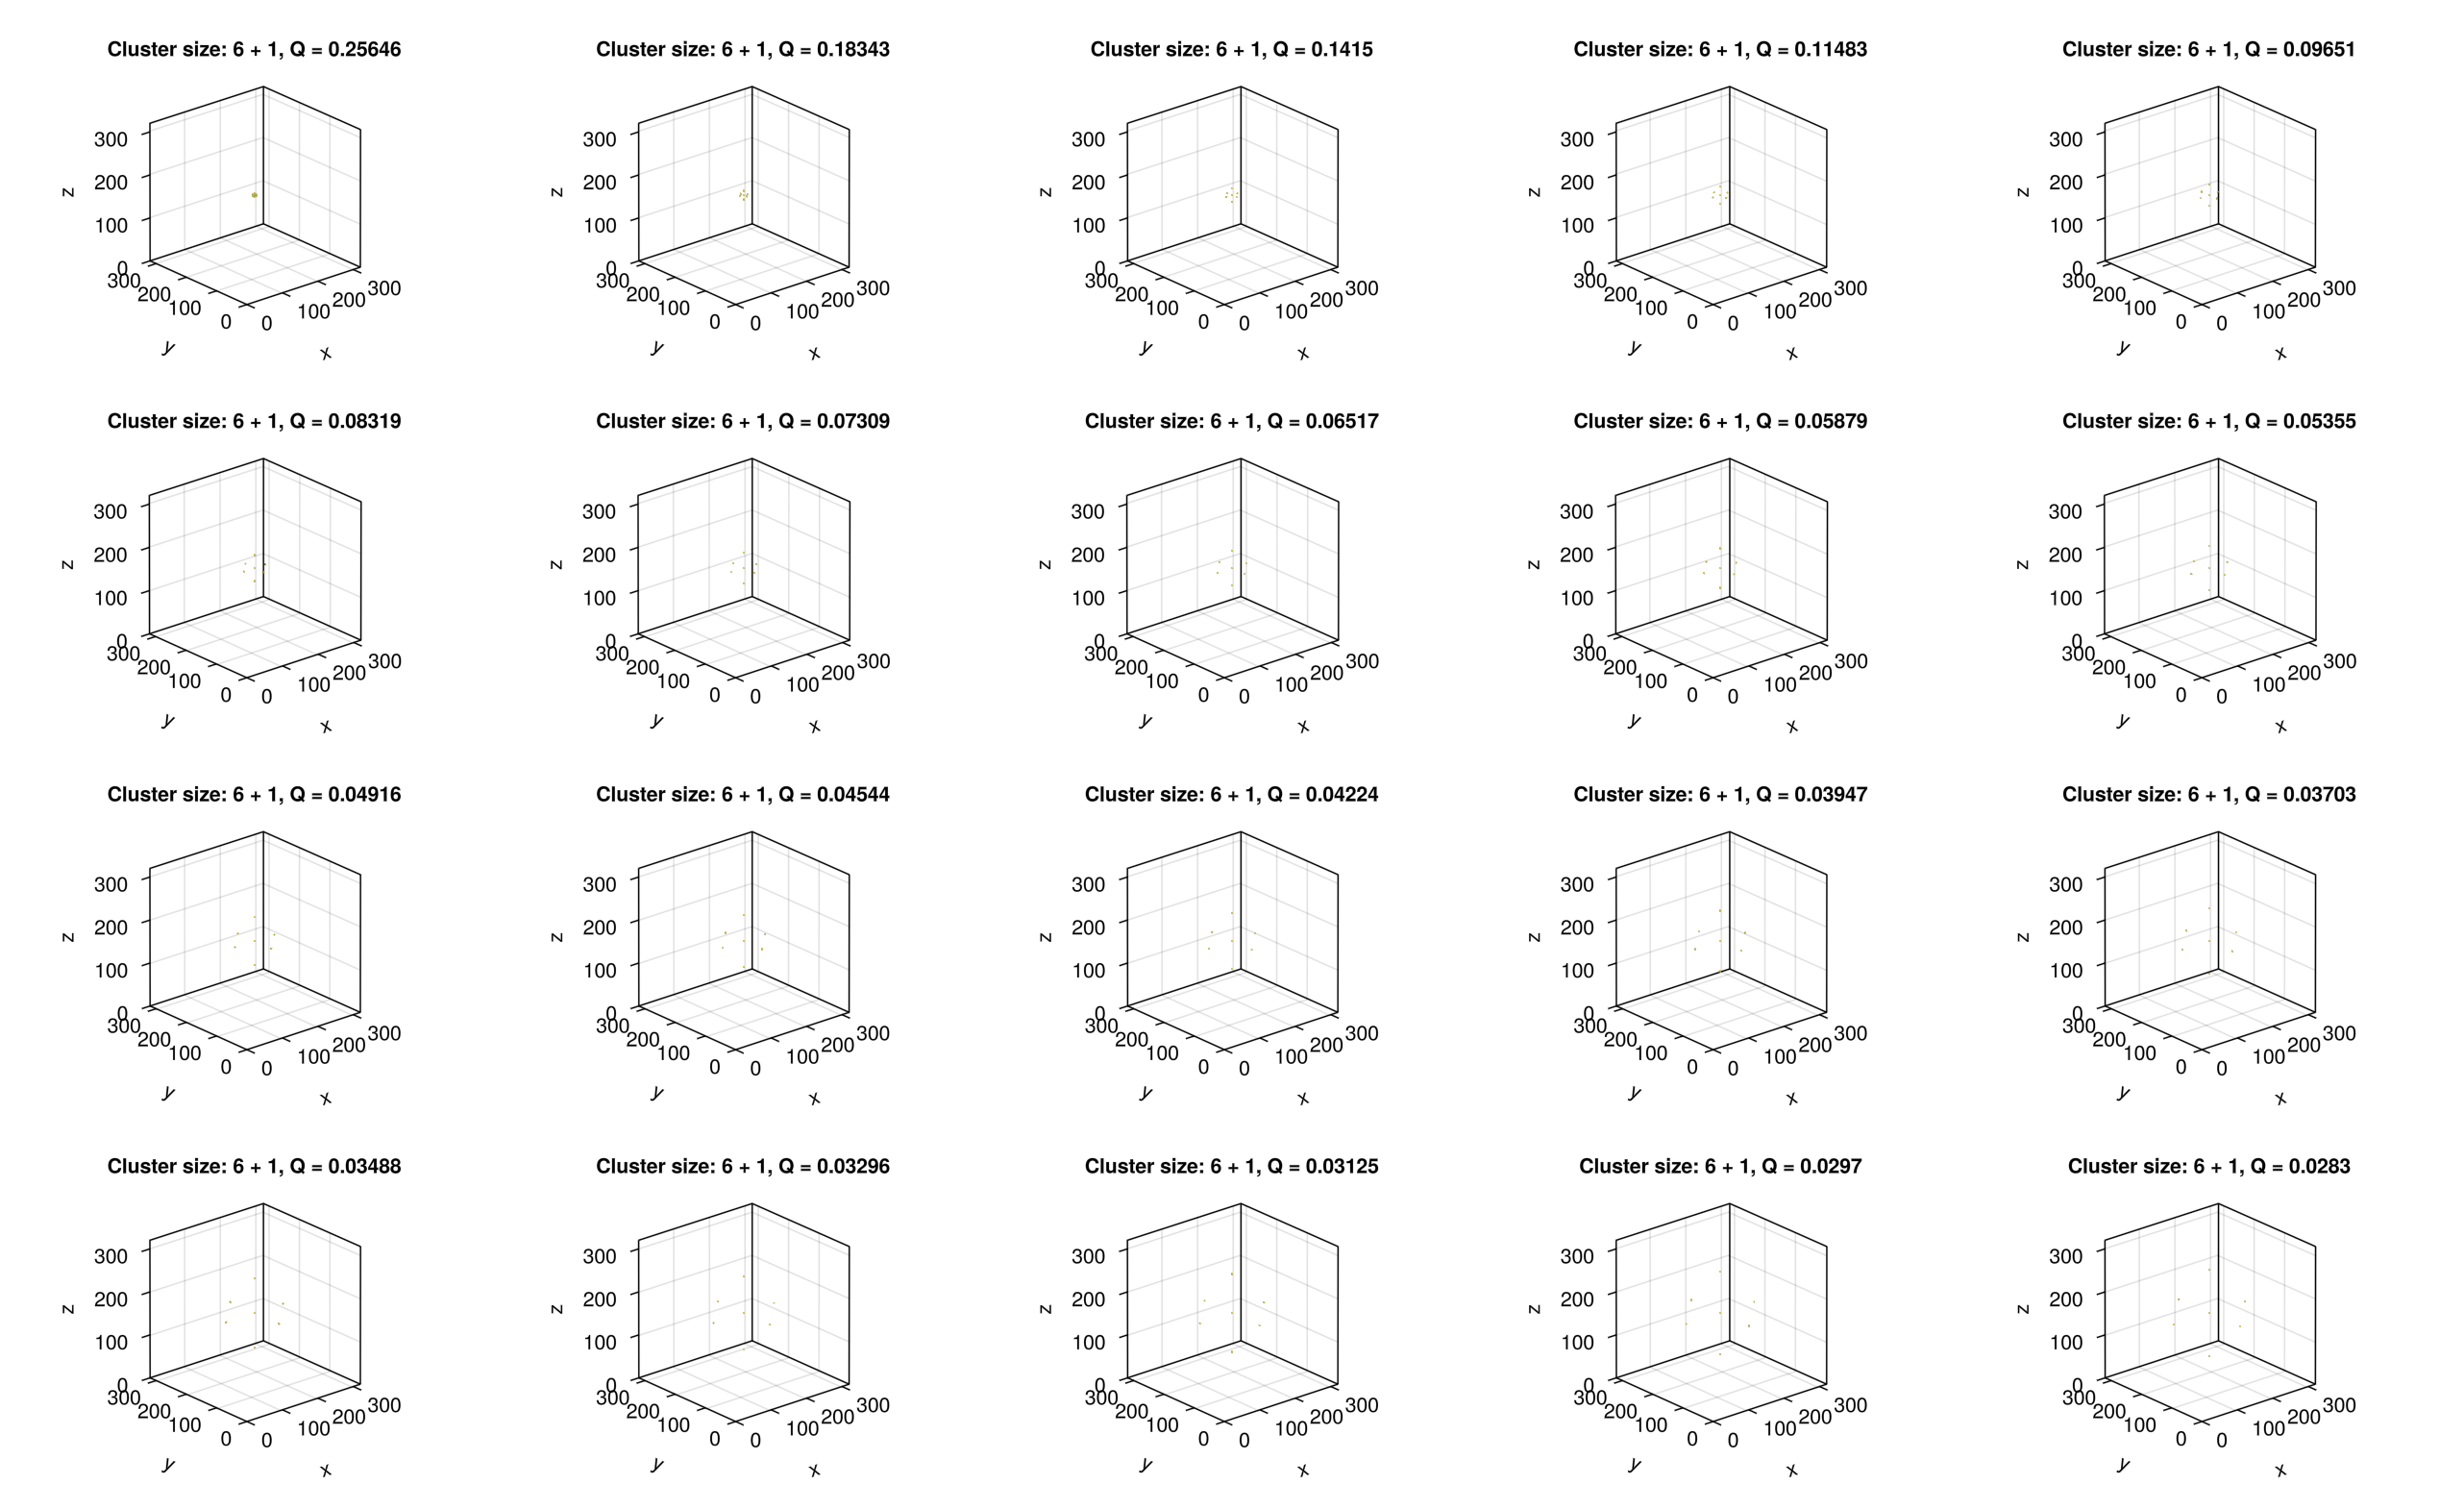

GLMakie.Screen(...)

In [ ]:
# Visualise cluster
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
distances = collect(1:20) * spore_diameter
println(distances)
n_nbrs = [6 for _ in distances]
plot_spore_clusters(n_nbrs, spore_rad, 320, 5; spore_spacings=distances)

[6 hrs run time]

In [4]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 100#3600 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
V_spore_sphere = 4π * (spore_diameter / 2)^3 / 3 # microns^3
A_spore_sphere = 4π * (spore_diameter / 2)^2 # microns^2
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Distance ranges
dist_range_hr = collect(1:0.25:2.5) * spore_diameter
dist_range_mr = collect(2:20) * spore_diameter
dist_range_lr = collect(4:4:20) * spore_diameter

# Simulation parameters
n_save_frames = 100

# High-resolution setup
N = 256
dx = 0.2
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)
cluster_params = [(2, true), (2, false), (6, true), (6, false)] # (neighbours, trim)

# Run high-resolution simulation
coverage_hr = zeros(Float64, length(cluster_params), length(dist_range_hr))
exponents_hr = zeros(Float64, length(cluster_params), length(dist_range_hr))
frame_samples_hr = zeros(Float64, length(cluster_params), length(dist_range_mr), n_save_frames+1, N, N)
for (i, (cluster_size, trim)) in enumerate(cluster_params)
    for (j, dist) in enumerate(dist_range_hr)
        sp_cen_indices = setup_spore_cluster(cluster_size, N, 0.5 * dist / dx + 0.5, trim) # with safety radius of 0.5
        coverage_hr[i, j] = measure_coverage(sp_cen_indices[1], sp_cen_indices[2:end], rad=spore_rad, dx=dx)
        c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(copy(c_init), c0_cw, sp_cen_indices, spore_rad, t_max;
                                                                                                                D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                                crank_nicolson=false, abs_bndry=true)
        frame_samples_hr[i, j, :, :, :] .= c_frames
        fit = exp_fit(times_numerical, c_numerical)
        exponents_hr[i, j] = fit[2]
    end
end

# Mid-resolution setup
N = 256
dx = 5
dt = 0.005
c_init = zeros(Float64, N, N, N)
cluster_sizes = [2, 3, 5, 6]

# Run mid-resolution simulation
coverage_mr = zeros(Float64, length(cluster_sizes), length(dist_range_mr))
exponents_mr = zeros(Float64, length(cluster_sizes), length(dist_range_mr))
frame_samples_mr = zeros(Float64, length(cluster_sizes), length(dist_range_mr), n_save_frames+1, N, N)
for (i, cluster_size) in enumerate(cluster_sizes)
    for (j, dist) in enumerate(dist_range_mr)
        # Only for computation of coverage
        sp_cen_indices = setup_spore_cluster(2, N, 0.5 * dist / dx, true) # additive single neighbour contributions
        coverage_mr[i, j] = cluster_size * measure_coverage(sp_cen_indices[1], sp_cen_indices[2:end], rad=spore_rad, dx=dx)
        
        # Run simulation
        c_init = zeros(Float64, N, N, N)
        c_init[N ÷ 2, N ÷ 2, N ÷ 2] = c0_spore
        c_numerical, times_numerical = diffusion_time_dependent_GPU!(copy(c_init), t_max; D=D, Ps=Ps_fit, dt=dt, dx=dx,
                                                                        n_save_frames=n_save_frames, spore_idx=sp_cen_indices[1],
                                                                        cluster_size=cluster_size, cluster_spacing=dist)
        fit = exp_fit(times_numerical, c_numerical[:, sp_cen_indices[1]...])
        exponents_mr[i, j] = fit[2]
        frame_samples_mr[i, j, :, :, :] .= c_numerical[:, :, N ÷ 2, :]
    end
end

# Low-resolution setup
N = 64
dx = 20
dt = 0.1
c_init = zeros(Float64, N, N, N)
cluster_sizes = [2, 3, 5, 6]

# Run mid-resolution simulation
coverage_lr = zeros(Float64, length(cluster_sizes), length(dist_range_mr))
exponents_lr = zeros(Float64, length(cluster_sizes), length(dist_range_mr))
frame_samples_lr = zeros(Float64, length(cluster_sizes), length(dist_range_mr), n_save_frames+1, N, N, N)
for (i, cluster_size) in enumerate(cluster_sizes)
    for (j, dist) in enumerate(dist_range_lr)
        # Only for computation of coverage
        sp_cen_indices = setup_spore_cluster(2, N, 0.5 * dist / dx, true) # additive single neighbour contributions
        coverage_lr[i, j] = cluster_size * measure_coverage(sp_cen_indices[1], sp_cen_indices[2:end], rad=spore_rad, dx=dx)
        
        # Run simulation
        c_med_evolution, c_spore_evolution, times_numerical, _ = diffusion_time_dependent_GPU_low_res(copy(c_init), c0_spore, t_max; D=D, Pₛ=Ps_fit, A=A_spore_sphere, V=V_spore_sphere, dt=dt, dx=dx,
                                                                            n_save_frames=n_save_frames, spore_vol_idx=sp_cen_indices[1],
                                                                            cluster_size=cluster_size, cluster_spacing=dist)
        fit = exp_fit(times_numerical, c_spore_evolution)
        exponents_lr[i, j] = fit[2]
        frame_samples_lr[i, j, :, :, :, :] .= c_med_evolution
    end
end

Using D = 600, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 6.688382673779544e-5, Dcw*dt/dx2 = 3.344191486004655e-5
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
Frame 100 saved.Using D = 600, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 6.688382673779544e-5, Dcw*dt/dx2 = 3.344191486004655e-5
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
Frame 100 saved.Using D = 600, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 6.688382673779544e-5, Dcw*dt/dx2 = 3.344191486004655e-5
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
Frame 100 saved.Using D = 600, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 6.6883826737795

In [8]:
dist_range_mr = collect(2:4:20) * spore_diameter

5-element Vector{Int64}:
 10
 30
 50
 70
 90

In [12]:
t_max= 100
dist = 10 * spore_diameter
cluster_size = 6
sp_cen_indices = setup_spore_cluster(2, N, 0.5 * dist / dx, true) # additive single neighbour contributions

# Run simulation
c_init = zeros(Float64, N, N, N)
c_init[N ÷ 2, N ÷ 2, N ÷ 2] = c0_spore
c_numerical, times_numerical = diffusion_time_dependent_GPU!(copy(c_init), t_max; D=D, Ps=Ps_fit, dt=dt, dx=dx,
                                                                n_save_frames=n_save_frames, spore_idx=sp_cen_indices[1],
                                                                cluster_size=cluster_size, cluster_spacing=dist)

Using D = 600, Db = 0.0013376765347559091, Ps = 0.0002675353069511818
Storage arrays allocated.
Frame 100 saved.

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

Plotting frames: [1, 101]


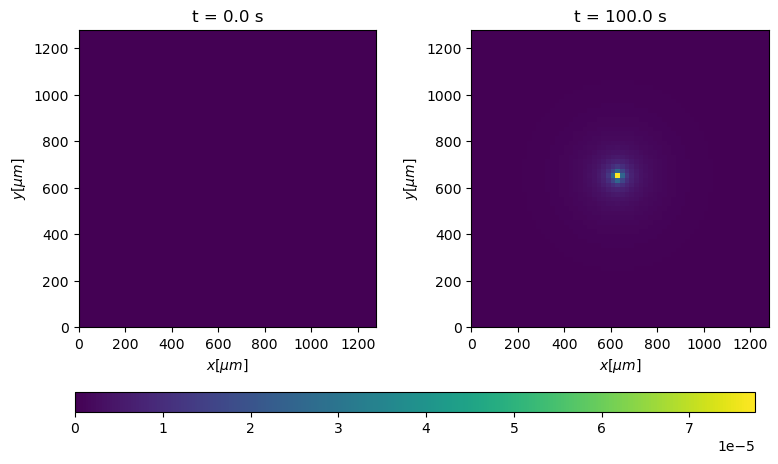

In [63]:
times_numerical = collect(0:(t_max/n_save_frames):t_max)
plot_concentration_lattice(frame_samples_lr[1, 1, :, N÷2, :, :], dx, frame_indices=[1, 101], times=times_numerical)

In [88]:
dist_groups = [dist_range_hr, dist_range_mr, dist_range_lr]
exp_groups = [exponents_hr, exponents_mr, exponents_lr]
labels_base = ["High resolution", "Medium resolution", "Low resolution"]
cluster_sizes = [2, 3, 5, 6]
labels = [[string(label, ", ", cluster_size, " spores") for cluster_size in cluster_sizes] for label in labels_base]
println(typeof(labels))
compare_functional_relationships_groups(dist_groups, exp_groups, ["Distance", "Decay exponent"], labels, "Centre-to-centre distance vs. decay exponent", logy=false, fit=nothing)

Vector{Vector{String}}
Matrix{Vector{Float64}}
Matrix{Matrix{Float64}}
Vector{Vector{String}}


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\mihbo\.julia\packages\PyCall\1gn3u\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (7,) and (4, 7)')
  File "C:\Users\mihbo\.julia\conda\3\x86_64\Lib\site-packages\matplotlib\axes\_axes.py", line 1777, in plot
    lines = [*self._get_lines(self, *args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mihbo\.julia\conda\3\x86_64\Lib\site-packages\matplotlib\axes\_base.py", line 297, in __call__
    yield from self._plot_args(
               ^^^^^^^^^^^^^^^^
  File "C:\Users\mihbo\.julia\conda\3\x86_64\Lib\site-packages\matplotlib\axes\_base.py", line 494, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "
